In [1]:
import sys; sys.path.append('..')
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from src.utils.metrics import (
    compute_average_accuracy,
    compute_forgetting_measure,
    compute_learning_curve_area,
    compute_ausuc,
    compute_ausuc_matrix,
    compute_individual_accs_matrix,
    compute_task_transfer_matrix,
    compute_seen_classes_acc_history,
    compute_unseen_classes_acc_history,
    compute_joined_ausuc_history,
    compute_acc_for_classes
)

In [2]:
dataset, tasks = 'cub', np.arange(1, 11)
# dataset, tasks = 'awa', np.arange(1, 6)

experiments_dir = '../experiments'
find_exps = lambda prefix: [e for e in os.listdir(experiments_dir) if e.startswith(prefix)]
# method_to_prefix = {
#     'Basic': f'basic-{dataset}',
#     'Joint': f'joint-{dataset}',
#     'EWC': f'ewc-{dataset}',
#     'MAS': f'mas-{dataset}',
#     'A-GEM': f'agem-{dataset}',
#     'GM_attrs_pretrained': f'lat_gm-{dataset}_attrs-in-gen',
#     #'GM_attrs_non-pretrained': f'lat_gm-{dataset}_attrs-in-gen_non-pretrained',
#     'GM_no-attrs_pretrained': f'lat_gm-{dataset}_no-attrs-in-gen',
#     #'GM_no-attrs_non-pretrained': f'lat_gm-{dataset}_no-attrs-in-gen_non-pretrained',
# }
# methods, prefixes = zip(*method_to_prefix.items())
# methods = [m[:-8] for m in os.listdir(experiments_dir) if not 'awa' in m]
methods = [
 'lat_gm--cub-hp.num_iters_per_task=250_hp.creativity.enabled=True_hp.creativity.adv_coef=0.1_hp.creativity.entropy_coef=0.1',
 'lat_gm--cub-hp.num_iters_per_task=250_hp.creativity.enabled=False_hp.reg_strategy=ewc_hp.synaptic_strength=0.01',
 'joint-sgd-cub-',
 'basic-sgd-cub-',
 'agem-sgd-cub-',
 'ewc-sgd-cub-hp.synaptic_strength=0.01',
 'mas-sgd-cub-hp.synaptic_strength=0.01',
 'lat_gm_vae--cub-hp.num_iters_per_task=100']
prefixes = methods
exps = {m: find_exps(p) for m, p in zip(methods, prefixes)}

exps = {m: [e for e in exps[m] if os.path.exists(f'{experiments_dir}/{e}/custom_data/logits_history.npy')] for m in exps}
exps = {m: [e for e in exps[m] if os.path.exists(f'{experiments_dir}/{e}/custom_data/targets.npy')] for m in exps}
exps = {m: [e for e in exps[m] if os.path.exists(f'{experiments_dir}/{e}/custom_data/class_splits.npy')] for m in exps}
exps = {m: exps[m] for m in exps if len(exps[m]) > 0}
methods = list(exps.keys())

logits_histories = {m: [np.load(f'{experiments_dir}/{e}/custom_data/logits_history.npy') for e in exps[m]] for m in exps}
targets = {m: [np.load(f'{experiments_dir}/{e}/custom_data/targets.npy') for e in exps[m]] for m in exps}
class_splits = {m: [np.load(f'{experiments_dir}/{e}/custom_data/class_splits.npy') for e in exps[m]] for m in exps}

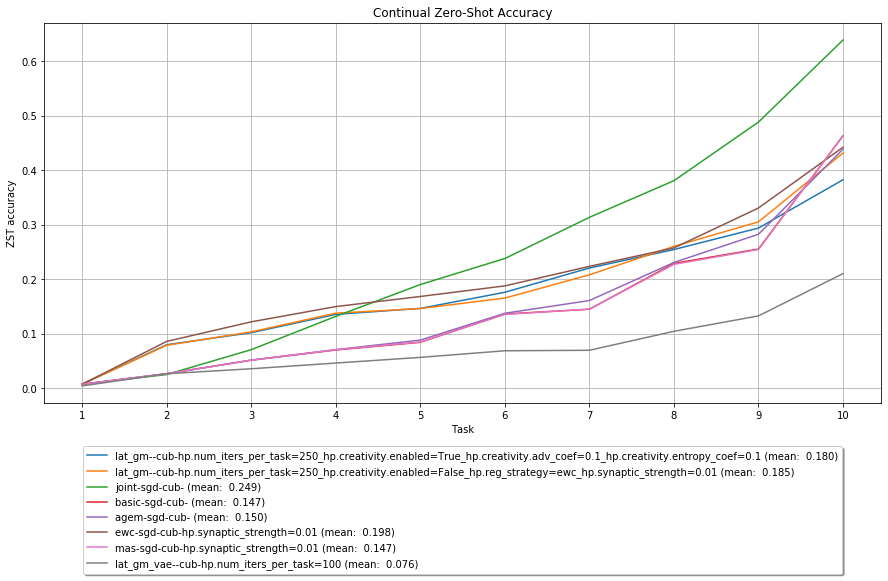

In [3]:
plt.figure(figsize=(15, 7))
plt.title('Continual Zero-Shot Accuracy')

for method in methods:
    values = [compute_unseen_classes_acc_history(l, t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks, values_avg, label=f'{method} (mean: {values_avg.mean(): .3f})')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.xlabel('Task')
plt.ylabel('ZST accuracy')
plt.xticks(tasks)
plt.grid()

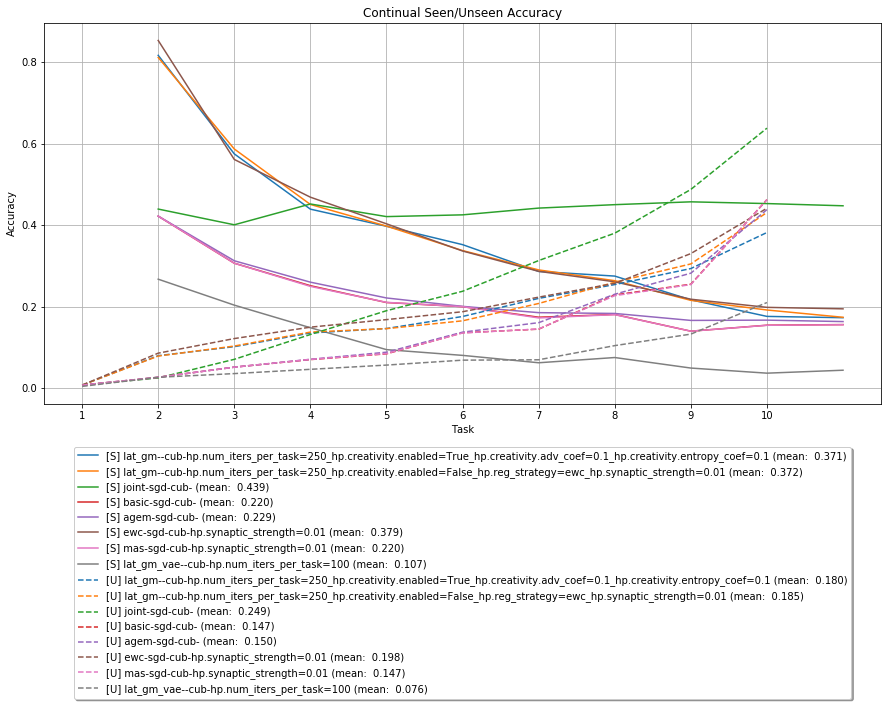

In [4]:
from matplotlib.colors import BASE_COLORS

# colors = list(BASE_COLORS.keys())
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(15, 7))
plt.title('Continual Seen/Unseen Accuracy')

for i, method in enumerate(methods):
    values = [compute_seen_classes_acc_history(l[1:], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks + 1, values_avg, label=f'[S] {method} (mean: {values_avg.mean(): .3f})', color=colors[i % len(colors)])
    #plt.plot(tasks, values_avg, label=f'[S] {method} (mean: {values_avg.mean(): .3f})')
    
for i, method in enumerate(methods):
    values = [compute_unseen_classes_acc_history(l, t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks, values_avg, '--', label=f'[U] {method} (mean: {values_avg.mean(): .3f})', color=colors[i % len(colors)])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.xticks(tasks)
plt.grid()

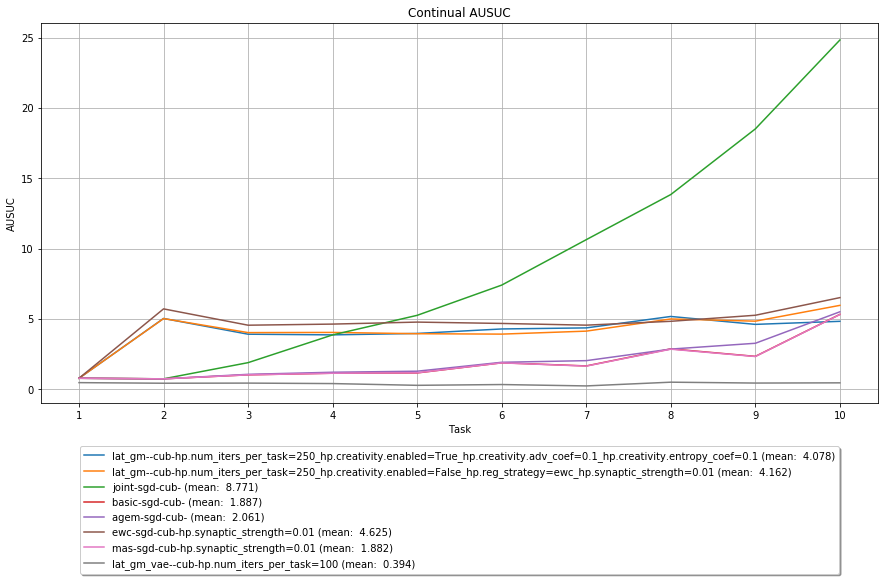

In [5]:
plt.figure(figsize=(15, 7))
plt.title('Continual AUSUC')

for method in methods:
    values = [compute_joined_ausuc_history(l, t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks, values_avg, label=f'{method} (mean: {values_avg.mean(): .3f})')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.xlabel('Task')
plt.ylabel('AUSUC')
plt.xticks(tasks)
plt.grid()

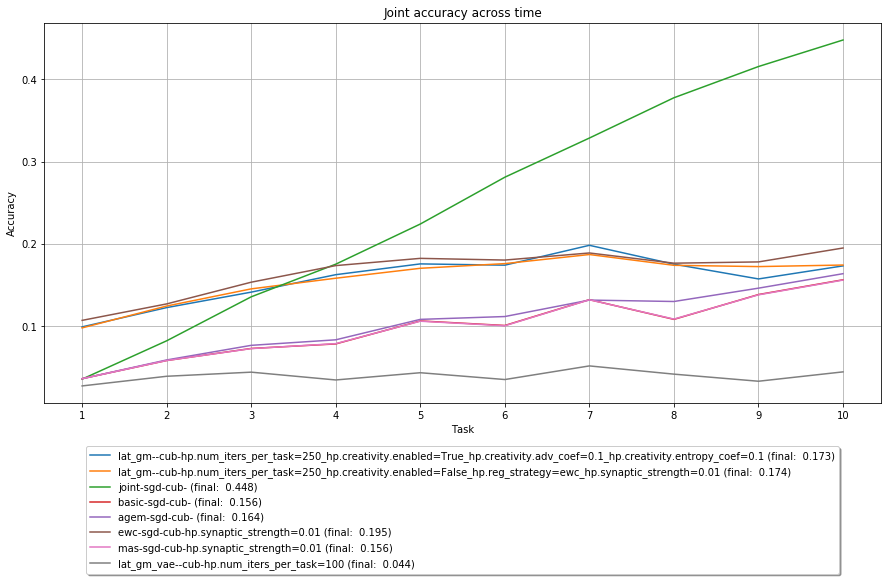

In [6]:
plt.figure(figsize=(15, 7))
plt.title('Joint accuracy across time')

for method in methods:
    values = [(l[1:].argmax(axis=2) == t.reshape(1, -1)).mean(1) for l, t in zip(logits_histories[method], targets[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks, values_avg, label=f'{method} (final: {values_avg[-1]: .3f})')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.xticks(tasks)
plt.grid()

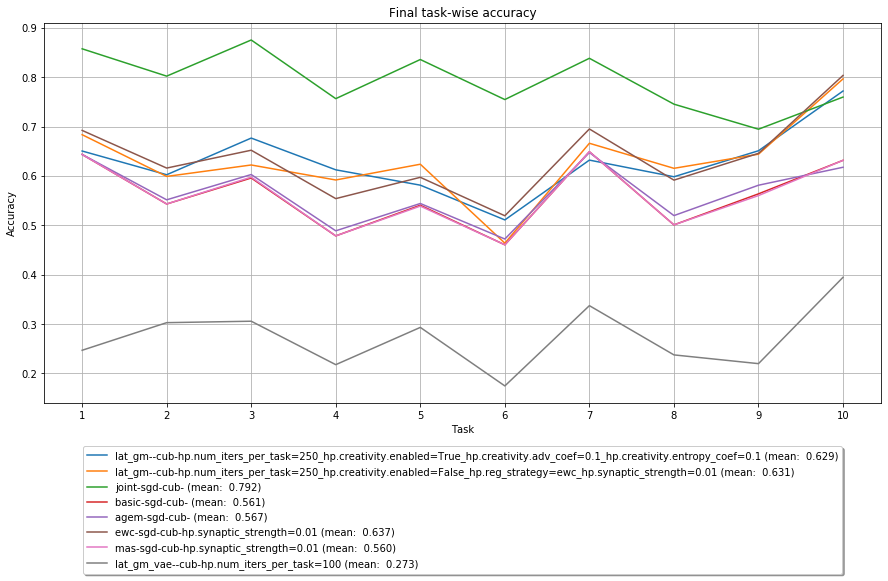

In [7]:
plt.figure(figsize=(15, 7))
plt.title('Final task-wise accuracy')

for method in methods:
    values = [[compute_acc_for_classes(l[-1], t, cs) for cs in c] for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks, values_avg, label=f'{method} (mean: {values_avg.mean(): .3f})')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.xticks(tasks)
plt.grid()

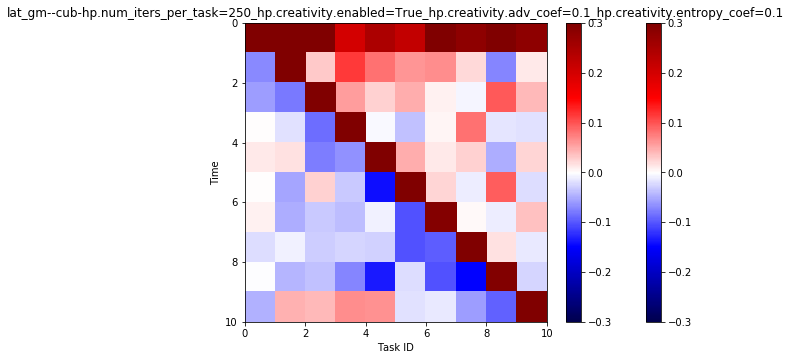

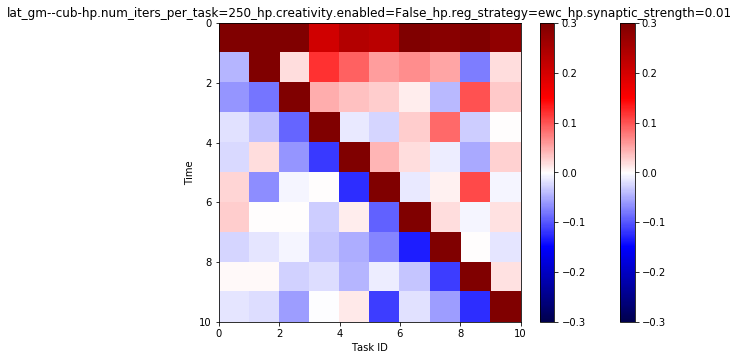

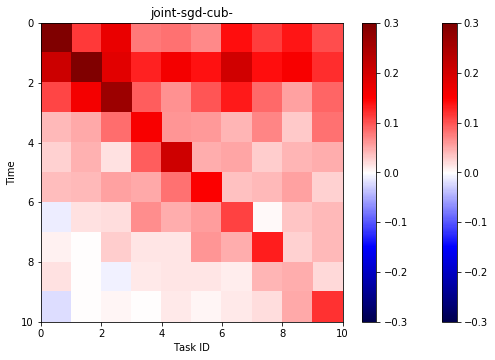

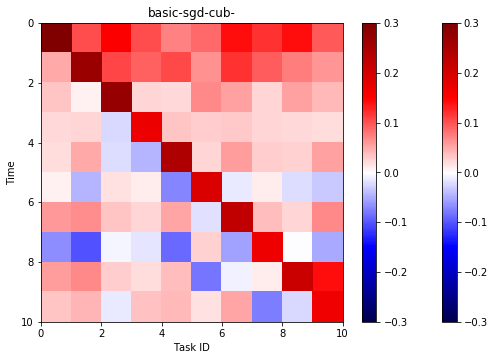

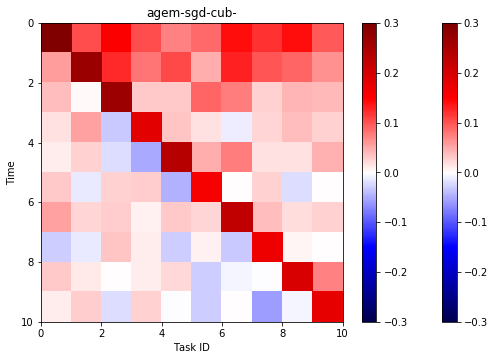

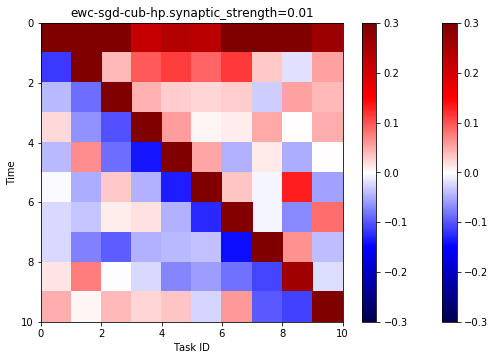

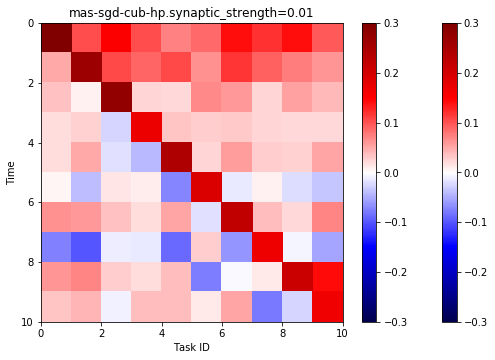

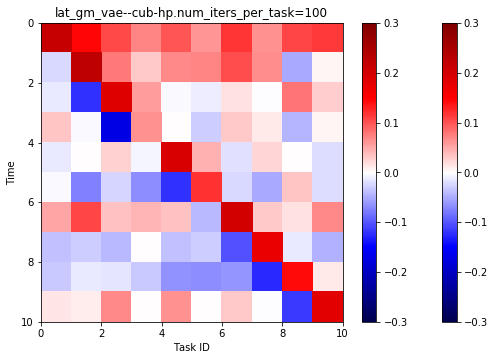

In [10]:
from tqdm import tqdm

def plot_task_transfer_matrix(values, title: str=''):
    # https://stackoverflow.com/questions/35727374/creating-a-matplotlib-heatmap-with-two-different-coloured-data-sets

    mask_red = np.triu(np.ones_like(values), k=1).astype(bool)
    mask_blue = np.tril(np.ones_like(values), k=0).astype(bool)

    values_red = np.ma.masked_where(~mask_red, values)
    values_blue = np.ma.masked_where(~mask_blue, values)

    # # Make a side-by-side plot
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title(title)
    redmesh = ax.pcolormesh(values_red, cmap='seismic', vmin=-0.3, vmax=0.3)
    bluemesh = ax.pcolormesh(values_blue, cmap='seismic', vmin=-0.3, vmax=0.3)
    # plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.xlabel('Task ID')
    plt.ylabel('Time')

    # Add dual colorbars
    fig.subplots_adjust(bottom=0.05, right=0.78, top=0.88, wspace=0, hspace=0)
    cbar = fig.colorbar(redmesh)
    cbar = fig.colorbar(bluemesh)
    plt.show()


# plt.figure(figsize=(20, 5 * 2))

for i, method in enumerate(methods):
    values_acc = [compute_task_transfer_matrix(l, t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_acc_avg = np.array(values_acc).mean(0)
    plot_task_transfer_matrix(values_acc_avg, method)
    
#     plt.subplot(3, 3, i + 1)
#     plt.title(f'Task accuracies for [{method}]')
#     plt.imshow(values_acc_avg, cmap='Blues', vmin=0, vmax=1.)
#     plt.colorbar(fraction=0.046, pad=0.04)
#     plt.ylabel('Time')
#     plt.xlabel('Which task we score')
#     plt.xticks(tasks - 1, tasks);
#     plt.yticks(tasks - 1, tasks);

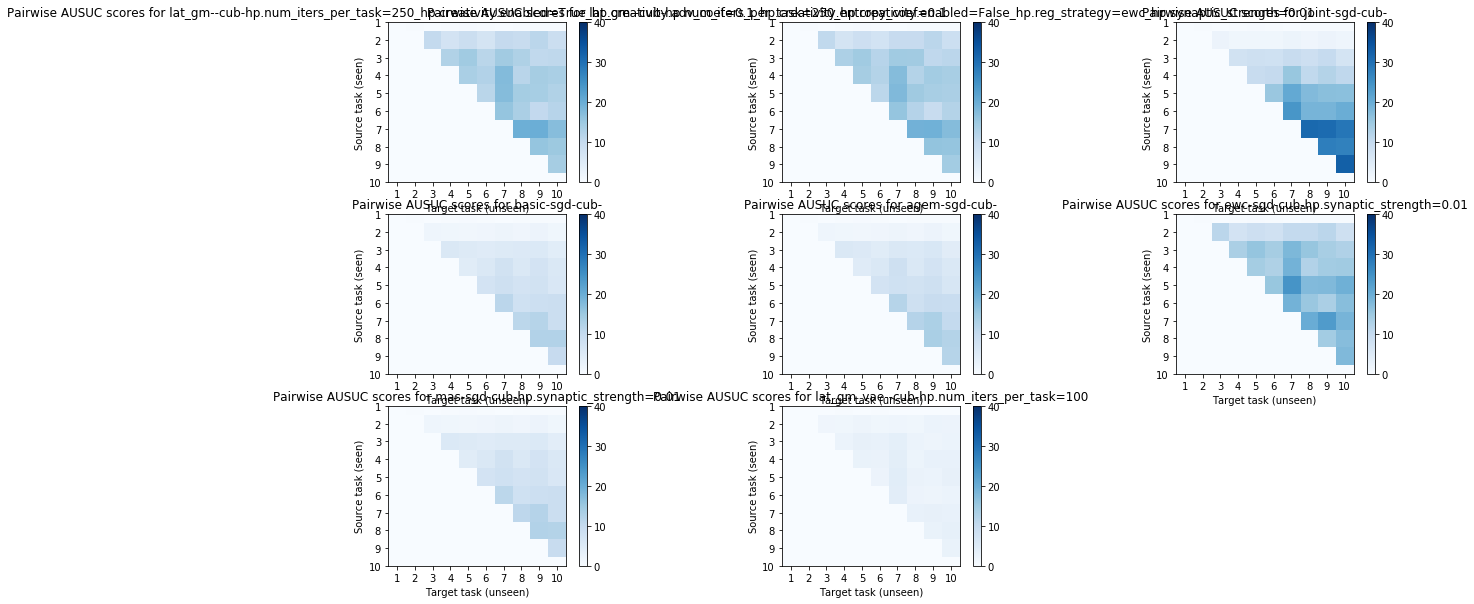

In [9]:
plt.figure(figsize=(20, 5 * 2))

for i, method in enumerate(methods):
    values_ausuc = [compute_ausuc_matrix(l[:-1], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]    
    values_ausuc_avg = np.array(values_ausuc).mean(0)
    
    plt.subplot(3, 3, i + 1)
    plt.title(f'Pairwise AUSUC scores for {method}')
    plt.imshow(np.triu(values_ausuc_avg, k=1), cmap='Blues', vmin=0, vmax=40)
    plt.colorbar(fraction=0.046, pad=0.04)
    #plt.clim(0, 100)
    plt.ylabel('Source task (seen)')
    plt.xlabel('Target task (unseen)')
    plt.xticks(tasks - 1, tasks);
    plt.yticks(tasks - 1, tasks);

In [37]:
# for method in methods:
#     values_acc = [compute_individual_accs_matrix(l[1:], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
#     values_ausuc = [compute_ausuc_matrix(l[:-1], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    
#     values_acc_avg = np.array(values_acc).mean(0)
#     values_ausuc_avg = np.array(values_ausuc).mean(0)

#     plt.figure(figsize=(15, 7))
    
#     plt.subplot(121)
#     plt.title(f'Task accuracies for [{method}]')
#     plt.imshow(values_acc_avg, cmap='Blues', vmin=0, vmax=1.)
#     plt.colorbar(fraction=0.046, pad=0.04)
#     #plt.clim(0, 1)
#     plt.ylabel('Time')
#     plt.xlabel('Which task we score')
#     plt.xticks(tasks - 1, tasks);
#     plt.yticks(tasks - 1, tasks);

#     plt.subplot(122)
#     plt.title(f'Pairwise AUSUC scores for [{method}]')
#     plt.imshow(np.triu(values_ausuc_avg), cmap='Blues', vmin=0, vmax=70)
#     plt.colorbar(fraction=0.046, pad=0.04)
#     #plt.clim(0, 100)
#     plt.ylabel('Time')
#     plt.xlabel('Which task we score')
#     plt.xticks(tasks - 1, tasks);
#     plt.yticks(tasks - 1, tasks);